In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import RELACS as rel
sns.set_style("white")
sns.set_context("paper")
%load_ext rpy2.ipython
%matplotlib inline

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [52]:
clust = pd.read_csv("../../figure_1/INTERMEDIATE_FILES/H3K79me2_3kbDownTSS_mESC_NPC48h_5cl.txt",sep="\t")
genes_H3K79me2_positive = clust.loc[(clust.deepTools_group == "cluster_1") | (clust.deepTools_group == "cluster_2") | (clust.deepTools_group == "cluster_3")]["name"].unique()
len(genes_H3K79me2_positive)

8268

In [3]:
%%bash

### annotate random peaks

# source activate Homer

# annotatePeaks.pl ../INTERMEDIATE_FILES/Random_ATAC_peaks_1000.bed mm10 \
# -gtf /home/ferrari/ferrari/my_repository/annotations_gencode/mouse/M18/annotation_snakePipes/gencode.vM18.annotation.sorted.gtf \
# > ../INTERMEDIATE_FILES/Random_ATAC_peaks_1000.annotated

In [4]:
%%bash 

# multiBamSummary BED-file -b /home/ferrari/ferrari/PhD_project/reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_iNPC/filtered_bam/iNPC_DMSO_*_H3K79me2_merged.filtered.bam \
# -o ../INTERMEDIATE_FILES/NPC48h_H3K79me2_onATACpeaks_random.mat.gz \
# --BED  ../INTERMEDIATE_FILES/Random_ATAC_peaks_1000.bed \
# -bl /home/ferrari/ferrari/my_repository/blacklist_ChIP-Seq/GRCm38_General_readAttractingRegions.UseThisOne_DKFZ.bed \
# -p 20 \
# --outRawCounts ../INTERMEDIATE_FILES/NPC48h_H3K79me2_onATACpeaks_random.counts \
# -e \
# --minMappingQuality 5

In [5]:
%%bash

# extract_from_gtf.py -f TSS -w transcript -o ./ /home/ferrari/ferrari/my_repository/annotations_gencode/mouse/M18/annotation_snakePipes/gencode.vM18.annotation.sorted.gtf

In [53]:
atac = pd.read_csv("../INTERMEDIATE_FILES/Final_Table_topPC1ATACPeaks.tsv",sep="\t")
atac_down = atac.loc[(atac["4"] == "intron") & (atac.Loadings_PC1 >0)]
atac_up = atac.loc[(atac["4"] == "intron") & (atac.Loadings_PC1 <0)]

atac_down_introns_genes = atac_down.geneID.unique()
atac_up_introns_genes = atac_up.geneID.unique()


In [54]:
ref = pd.read_csv("../INTERMEDIATE_FILES/Random_ATAC_peaks_1000.bed",sep="\t",header=None,names=["chr","start","end"])
ref.index = ["{}_{}_{}".format(ref["chr"][i], ref["start"][i],ref["end"][i]) for i in range(ref.shape[0])]


rand = pd.read_csv("../INTERMEDIATE_FILES/Random_ATAC_peaks_1000.annotated", sep="\t")
rand.index = ["{}_{}_{}".format(rand["Chr"][i], str(int(rand["Start"][i])-1),rand["End"][i]) for i in range(rand.shape[0])]
rand['len'] = rand["End"].subtract(rand["Start"])
rand = rand[["Annotation","len"]]
rand["Annotation_class"] = [i.strip().split("(")[0] for i in rand["Annotation"].values]
rand["gene"] = [i.strip().split("(")[1].split(")")[0].split(",")[0] if len(i.strip().split("("))>1 else i for i in rand["Annotation"].values]
rand

tr = pd.read_csv("TSS.bed", sep="\t", index_col=7, header=None, names=['chr','start','end',"geneID","sc","strand","symbol"])
tr = tr["geneID"].to_dict()
tr

rand["gene"] = [tr[i] if i in tr else i for i in rand["gene"]]
rand.sort_values(by=list(rand)[0])

k79 = pd.read_csv("../INTERMEDIATE_FILES/NPC48h_H3K79me2_onATACpeaks_random.counts",sep="\t")
k79 = rel.preprocess_deeptools(k79)
k79["mean_k79"] = k79[list(k79)[:2]].mean(axis=1)
k79
rand_ = rand.merge(k79[["mean_k79"]], how='right', right_index=True, left_index=True)
out = list(atac_down["peak_id"].values) + list(atac_up["peak_id"].values)
out_ = list(set(out).intersection(set(rand_.index)))
out_
rand_["dens_H3K79me2"] = rand_["mean_k79"]/ (rand_["len"].values/1000)
rand_ = rand_.loc[[i not in out_ for i in rand_.index]]
                
rand_
atac_random = rand.loc[rand["Annotation_class"] == "intron "]["gene"].unique()


/home/ferrari/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


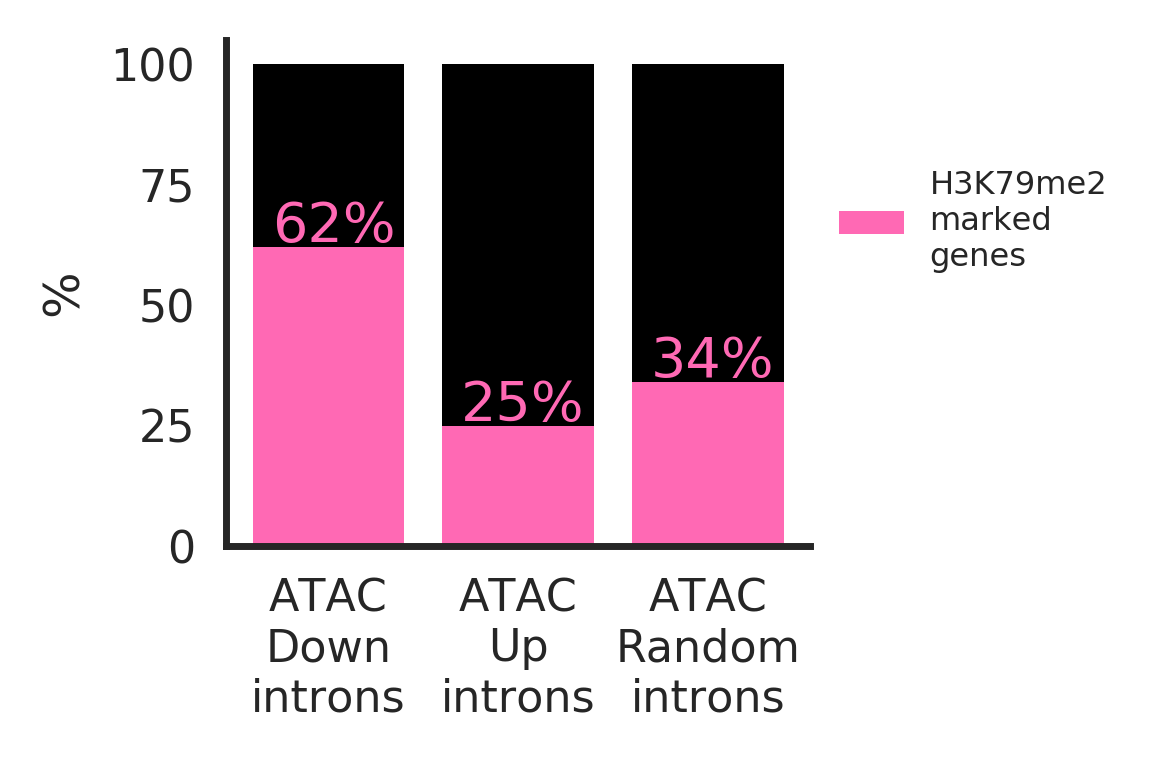

In [55]:
fig,ax = plt.subplots(dpi=400,figsize=(3,2))
atacdown_K79pl_genes = len(set(genes_H3K79me2_positive).intersection(set(atac_down_introns_genes)))
atacup_K79pl_genes = len(set(genes_H3K79me2_positive).intersection(set(atac_up_introns_genes)))
atacrand_K79pl_genes = len(set(genes_H3K79me2_positive).intersection(set(atac_random)))
maxim = 100

ax.bar([0,1,2],[maxim, maxim, maxim], width=0.8,color="k")
#label= "genes\nwith\ndynamic\nintronic\nATAC peaks"
ax.bar([0,1,2],[(maxim*atacdown_K79pl_genes)/len(atac_down_introns_genes), 
                (maxim*atacup_K79pl_genes)/len(atac_up_introns_genes),
                (maxim*atacrand_K79pl_genes/len(atac_random))],width=0.8, color="hotpink", label = "H3K79me2\nmarked\ngenes")
ax.set_xticks([0,1,2])
ax.set_xticklabels(["ATAC\nDown\nintrons","ATAC\nUp\nintrons","ATAC\nRandom\nintrons"])
ax.annotate("{}%".format(int((atacdown_K79pl_genes * 100)/len(atac_down_introns_genes))),(-0.3,((maxim*atacdown_K79pl_genes)/len(atac_down_introns_genes))+1), color='hotpink')
ax.annotate("{}%".format(int((atacup_K79pl_genes * 100)/len(atac_up_introns_genes))),(0.7,((maxim*atacup_K79pl_genes)/len(atac_up_introns_genes))+1), color='hotpink')
ax.annotate("{}%".format(int((atacrand_K79pl_genes * 100)/len(atac_random))),(1.7,((maxim*atacrand_K79pl_genes)/len(atac_random))+1), color='hotpink')



ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend(loc='best', fontsize="xx-small", bbox_to_anchor=(1, 0.8))
ax.set_ylabel("%")
plt.tight_layout()
# plt.savefig("../FIGURES/percent_H3K79mePositive_intronicATAC.pdf")

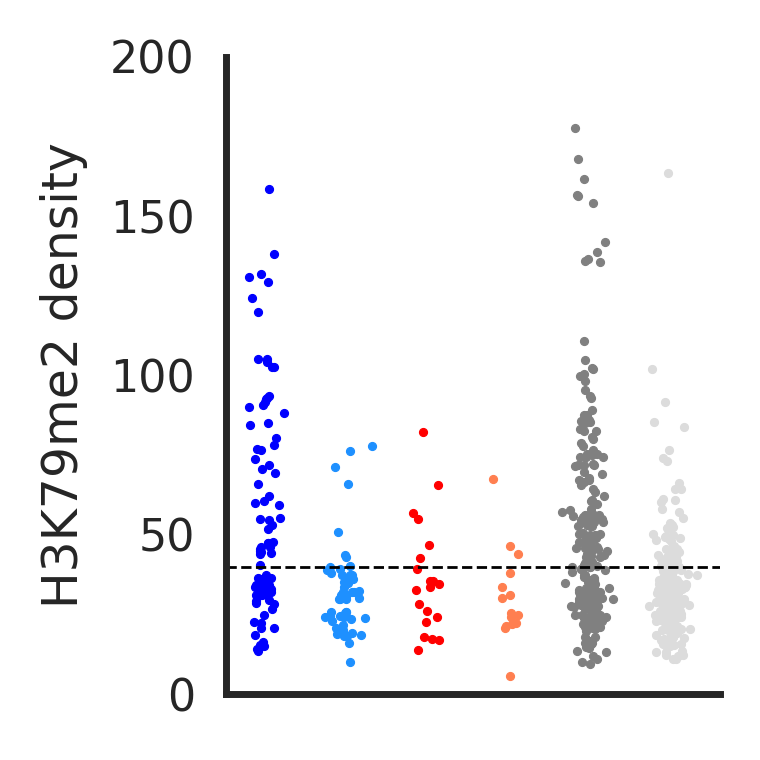

In [23]:
atac_introns_up = atac.loc[(atac["4"] == "intron")& (atac.Loadings_PC1 <0)].dens_H3K79me2.values
atac_intergenic_up = atac.loc[(atac["4"] == "Intergenic")& (atac.Loadings_PC1 <0)].dens_H3K79me2.values
atac_introns_down = atac.loc[(atac["4"] == "intron")& (atac.Loadings_PC1 >0)].dens_H3K79me2.values
atac_intergenic_down = atac.loc[(atac["4"] == "Intergenic")& (atac.Loadings_PC1 >0)].dens_H3K79me2.values
atac_introns_random = rand_.loc[(rand_["Annotation_class"] == "intron ")].dens_H3K79me2.values
atac_intergenic_random = rand_.loc[(rand_["Annotation_class"] == "Intergenic")].dens_H3K79me2.values


fig,ax = plt.subplots(dpi=400,figsize=(2,2))

ax.scatter(np.random.normal(loc=0, scale=0.1, size=len(atac_introns_down)), atac_introns_down, s=2, color = "blue")
# ax.scatter([0], np.mean(atac_introns_down), s=10, color = "k")

ax.scatter(np.random.normal(loc=1, scale=0.1, size=len(atac_intergenic_down)), atac_intergenic_down,s=2, color = "dodgerblue")
# ax.scatter([0], np.mean(atac_intergenic_down), s=10, color = "k")

ax.scatter(np.random.normal(loc=2, scale=0.1, size=len(atac_introns_up)), atac_introns_up, s=2, color = "red")

ax.scatter(np.random.normal(loc=3, scale=0.1, size=len(atac_intergenic_up)), atac_intergenic_up,s=2, color = "coral")

ax.scatter(np.random.normal(loc=4, scale=0.1, size=len(atac_introns_random)), atac_introns_random, s=2, color = "grey")

ax.scatter(np.random.normal(loc=5, scale=0.1, size=len(atac_intergenic_random)), atac_intergenic_random ,s=2, color = "gainsboro")


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.axhline(40,linewidth=0.5,linestyle="--",color="k")

ax.set_ylabel("H3K79me2 density")
ax.set_xticks([])
ax.set_ylim((0,200))

plt.tight_layout()

# plt.savefig("../FIGURES/ASSOCIATION_ATACDYNAMICS_H3K79me2Dens_intron_inter.png")


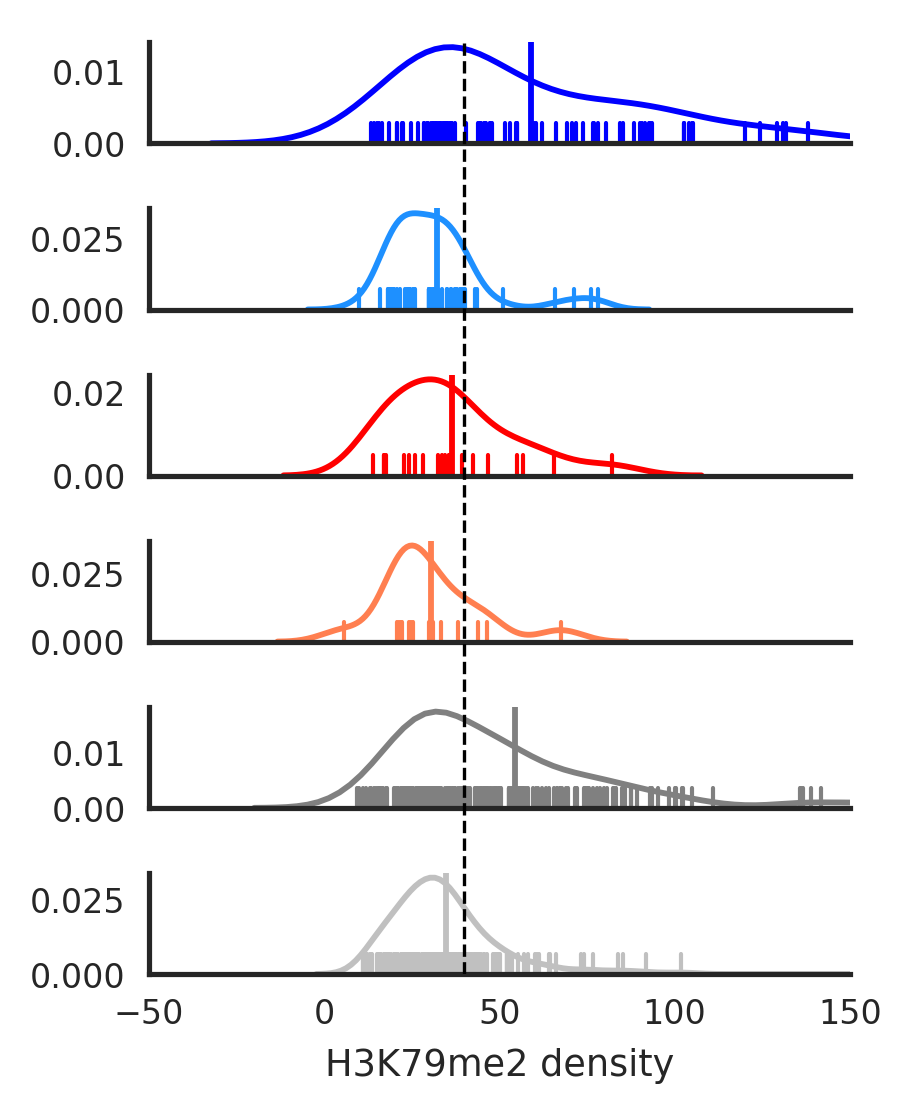

In [15]:
fig,ax=plt.subplots(6,1,dpi=300,sharex=True,figsize=(3.5,4))
ax[0].set_xlim((-50,150))
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)

ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)

ax[2].spines['right'].set_visible(False)
ax[2].spines['top'].set_visible(False)

ax[3].spines['right'].set_visible(False)
ax[3].spines['top'].set_visible(False)

ax[4].spines['right'].set_visible(False)
ax[4].spines['top'].set_visible(False)

ax[5].spines['right'].set_visible(False)
ax[5].spines['top'].set_visible(False)
#ax[0].axhline(0)

sns.distplot(atac_introns_down,ax=ax[0],hist=False, rug=True, rug_kws={'height':0.2}, color="b")
ax[0].axvline(np.mean(atac_introns_down),color="b")

sns.distplot(atac_intergenic_down,ax=ax[1],hist=False, rug=True, rug_kws={'height':0.2}, color="dodgerblue")
ax[1].axvline(np.mean(atac_intergenic_down),color="dodgerblue")

sns.distplot(atac_introns_up,ax=ax[2],hist=False, rug=True, rug_kws={'height':0.2}, color = "red")
ax[2].axvline(np.mean(atac_introns_up),color="red")

sns.distplot(atac_intergenic_up,ax=ax[3],hist=False, rug=True, rug_kws={'height':0.2}, color = "coral")
ax[3].axvline(np.mean(atac_intergenic_up),color="coral")

sns.distplot(atac_introns_random,ax=ax[4],hist=False, rug=True, rug_kws={'height':0.2}, color = "grey")
ax[4].axvline(np.mean(atac_introns_random),color="gray")

sns.distplot(atac_intergenic_random,ax=ax[5],hist=False, rug=True, rug_kws={'height':0.2}, color = "silver")
ax[5].axvline(np.mean(atac_intergenic_random),color="silver")

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlim((-50,150))
plt.axvline(40, linewidth=0.8,linestyle="--", color='k')
plt.xlabel("H3K79me2 density")

plt.tight_layout()

plt.savefig("../FIGURES/density_H3K79me2.png")


In [22]:
from scipy.stats import mannwhitneyu

print(np.mean(atac_introns_down) - np.mean(atac_introns_random))
mannwhitneyu(atac_introns_down, atac_introns_random, alternative="two-sided")


4.486614963157521


MannwhitneyuResult(statistic=11826.0, pvalue=0.11306764136353759)

In [ ]:
mannwhitneyu(atac_introns_down, atac_introns_random, alternative="two-sided")

In [45]:
%%bash

### plot H3K27ac metaprofile on open chromatin 

computeMatrix reference-point -R ../INTERMEDIATE_FILES/ATAC_topVar_PC1_LOADING-POSITIVE.tsv \
../INTERMEDIATE_FILES/ATAC_topVar_PC1_LOADING-NEGATIVE.tsv \
../INTERMEDIATE_FILES/Random_ATAC_peaks_1000.bed \
-S /home/ferrari/ferrari/PhD_project/reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_iNPC/deepTools_ChIP/bamCompare/iNPC_DMSO_rep*_H3K27ac_merged.filtered.log2ratio.over_iNPC_DMSO_rep*_Input.bw \
/home/ferrari/ferrari/PhD_project/reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_iNPC/deepTools_ChIP/bamCompare/iNPC_EPZ_rep*_H3K27ac_merged.filtered.log2ratio.over_iNPC_EPZ_rep*_Input.bw \
--referencePoint center -b 2000 -a 2000 \
-o ../INTERMEDIATE_FILES/H3K27ac_down_up_random_all.mat.gz --outFileSortedRegions ../INTERMEDIATE_FILES/H3K27ac_down_up_random_all.txt \
-p 20 --missingDataAsZero \
-bl /home/ferrari/ferrari/my_repository/blacklist_ChIP-Seq/GRCm38_General_readAttractingRegions.UseThisOne_DKFZ.bed \

In [48]:
%%bash

### plot H3K27ac metaprofile on open chromatin 

computeMatrix reference-point -R ../INTERMEDIATE_FILES/ATAC_topVar_PC1_LOADING-POSITIVE.tsv \
-S /home/ferrari/ferrari/PhD_project/reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_iNPC/deepTools_ChIP/bamCompare/iNPC_DMSO_rep*_H3K27ac_merged.filtered.log2ratio.over_iNPC_DMSO_rep*_Input.bw \
/home/ferrari/ferrari/PhD_project/reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_iNPC/deepTools_ChIP/bamCompare/iNPC_EPZ_rep*_H3K27ac_merged.filtered.log2ratio.over_iNPC_EPZ_rep*_Input.bw \
--referencePoint center -b 2000 -a 2000 \
-o ../INTERMEDIATE_FILES/H3K27ac_down.mat.gz --outFileSortedRegions ../INTERMEDIATE_FILES/H3K27ac_down.txt \
-p 20 --missingDataAsZero \
-bl /home/ferrari/ferrari/my_repository/blacklist_ChIP-Seq/GRCm38_General_readAttractingRegions.UseThisOne_DKFZ.bed \

In [51]:
%%bash

plotProfile -m ../INTERMEDIATE_FILES/H3K27ac_down_up_random_all.mat.gz -o ../FIGURES/H3K27ac_down_up_random_all.pdf \
--samplesLabel DMSO_1 DMSO_2 EPZ_1 EPZ_2 --regionsLabel ATAC_Down ATAC_Up ATAC_Random --yMax 2 --yMin -1 --perGroup --plotHeight 6 --plotWidth 6

In [43]:
%%bash

plotHeatmap -m ../INTERMEDIATE_FILES/H3K27ac_down_up_random_all.mat.gz -o ../FIGURES/H3K27ac_down_up_random_all_heatmap.png \
--samplesLabel DMSO_1 DMSO_2 EPZ_1 EPZ_2 --yMax 2 --yMin -1 --colorMap "RdBu_r"

In [50]:
%%bash

plotHeatmap -m ../INTERMEDIATE_FILES/H3K27ac_down.mat.gz -o ../FIGURES/H3K27ac_down_heatmap.png \
--samplesLabel DMSO_1 DMSO_2 EPZ_1 EPZ_2 --yMax 3.5 --yMin -1 --colorMap "RdBu_r" --kmeans 3

/home/ferrari/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning:

numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88



In [4]:
%%bash

### H3K27ac in H3K79me2 high and low regions

bedtools intersect -a ../INTERMEDIATE_FILES/ATAC_topVar_PC1_LOADING-POSITIVE.tsv -b ../INTERMEDIATE_FILES/NPC48h_Enhancers.MERGED.SORTED.Def.bed -wa | 

211


In [18]:
### H3K27ac in H3K79me2 high and low regions

at_dy = pd.read_csv("../INTERMEDIATE_FILES/Final_Table_topPC1ATACPeaks.tsv", sep="\t")
at_dy.loc[(at_dy.LogRatio < 0) & (at_dy.dens_H3K79me2 > 45) & (at_dy['5'] == 'yes')][["chr","start","end","peak_id"]].to_csv("../INTERMEDIATE_FILES/ATAC_low_H3K79me2High.bed",sep="\t",index=False, header=False)
at_dy.loc[(at_dy.dens_H3K79me2 < 45) & (at_dy['5'] == 'yes')][["chr","start","end","peak_id"]].to_csv("../INTERMEDIATE_FILES/ATAC_H3K79me2Low.bed",sep="\t",index=False, header=False)


In [31]:
%%bash

computeMatrix reference-point -R ../INTERMEDIATE_FILES/ATAC_low_H3K79me2High.bed \
../INTERMEDIATE_FILES/ATAC_H3K79me2Low.bed \
../INTERMEDIATE_FILES/Random_ATAC_peaks_1000.bed \
-S /home/ferrari/ferrari/PhD_project/reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_iNPC/bamCoverage/iNPC_DMSO_rep*_H3K27ac_merged.filtered.seq_depth_norm.bw \
/home/ferrari/ferrari/PhD_project/reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_iNPC/bamCoverage/iNPC_EPZ_rep*_H3K27ac_merged.filtered.seq_depth_norm.bw \
--referencePoint center -b 2000 -a 2000 \
-o ../INTERMEDIATE_FILES/H3K27ac_k79me_down_up_random.mat.gz --outFileSortedRegions ../INTERMEDIATE_FILES/H3K27ac_k79me_down_up_random.txt \
-p 20 --missingDataAsZero \
-bl /home/ferrari/ferrari/my_repository/blacklist_ChIP-Seq/GRCm38_General_readAttractingRegions.UseThisOne_DKFZ.bed \

In [38]:
%%bash

computeMatrix reference-point -R ../INTERMEDIATE_FILES/ATAC_low_H3K79me2High.bed \
../INTERMEDIATE_FILES/ATAC_H3K79me2Low.bed \
../INTERMEDIATE_FILES/Random_ATAC_peaks_1000.bed \
-S /home/ferrari/ferrari/PhD_project/reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_iNPC/bamCoverage/iNPC_DMSO_rep*_H3K4me1_merged.filtered.seq_depth_norm.bw \
/home/ferrari/ferrari/PhD_project/reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_iNPC/bamCoverage/iNPC_EPZ_rep*_H3K4me1_merged.filtered.seq_depth_norm.bw \
--referencePoint center -b 2000 -a 2000 \
-o ../INTERMEDIATE_FILES/H3K4me1_k79me_down_up_random.mat.gz --outFileSortedRegions ../INTERMEDIATE_FILES/H3K4me1_k79me_down_up_random.txt \
-p 20 --missingDataAsZero \
-bl /home/ferrari/ferrari/my_repository/blacklist_ChIP-Seq/GRCm38_General_readAttractingRegions.UseThisOne_DKFZ.bed \

In [42]:
%%bash

computeMatrix reference-point -R ../INTERMEDIATE_FILES/ATAC_onSigDown_NPC.bed \
../INTERMEDIATE_FILES/ATAC_onSigUP_NPC.bed \
../INTERMEDIATE_FILES/ATAC_onBackground_NPC.bed \
-S /home/ferrari/ferrari/PhD_project/reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_iNPC/bamCoverage/iNPC_DMSO_rep*_H3K27ac_merged.filtered.seq_depth_norm.bw \
/home/ferrari/ferrari/PhD_project/reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_iNPC/bamCoverage/iNPC_EPZ_rep*_H3K27ac_merged.filtered.seq_depth_norm.bw \
--referencePoint center -b 2000 -a 2000 \
-o ../INTERMEDIATE_FILES/H3K27ac_deg_down_up_random.mat.gz --outFileSortedRegions ../INTERMEDIATE_FILES/H3K27ac_deg_down_up_random.txt \
-p 20 --missingDataAsZero \
-bl /home/ferrari/ferrari/my_repository/blacklist_ChIP-Seq/GRCm38_General_readAttractingRegions.UseThisOne_DKFZ.bed \

In [22]:
# %%bash

# plotHeatmap -m ../INTERMEDIATE_FILES/H3K27ac_k79me_down_up_random.mat.gz -o ../FIGURES/H3K27ac_k79me_down_up_random.png \
# --samplesLabel DMSO_1 DMSO_2 EPZ_1 EPZ_2 --colorMap "RdBu_r" --perGroup

In [30]:
# %%bash

# plotProfile -m ../INTERMEDIATE_FILES/H3K27ac_k79me_down_up_random.mat.gz -o ../FIGURES/H3K27ac_k79me_down_up_random_Profile.png \
# --samplesLabel DMSO_1 DMSO_2 EPZ_1 EPZ_2 --perGroup --plotWidth 7 --yMax 2.5 --yMin -0.5

In [37]:
%%bash

plotProfile -m ../INTERMEDIATE_FILES/H3K27ac_k79me_down_up_random.mat.gz -o ../FIGURES/H3K27ac_k79me_down_up_random_Profile.pdf \
--samplesLabel DMSO_1 DMSO_2 EPZ_1 EPZ_2 --perGroup --plotWidth 7 --yMax 35 --yMin 0 \
--regionsLabel "Enhancers H3K79me2 high" "Enhancers H3K79me2 low" "ATAC Random"

In [45]:
%%bash

plotProfile -m ../INTERMEDIATE_FILES/H3K4me1_k79me_down_up_random.mat.gz -o ../FIGURES/H3K4me1_k79me_down_up_random_Profile.pdf \
--samplesLabel DMSO_1 DMSO_2 EPZ_1 EPZ_2 --perGroup --plotWidth 7 --yMax 20 --yMin 0 \
--regionsLabel "Enhancers H3K79me2 high" "Enhancers H3K79me2 low" "ATAC Random"

In [49]:
%%bash

plotProfile -m ../INTERMEDIATE_FILES/H3K27ac_deg_down_up_random.mat.gz -o ../FIGURES/H3K27ac_DEG_down_up_random_Profile.png \
--samplesLabel DMSO_1 DMSO_2 EPZ_1 EPZ_2 --perGroup --plotWidth 7 --yMax 50 --yMin 0 \
--regionsLabel "Enhancers H3K79me2 high" "Enhancers H3K79me2 low" "ATAC Random"